In [5]:
import json
import os
import torch
import numpy as np


### GET LINEAR EVAL RESULTS ###

#method_names = ['btwins', 'dc', 'moco', 'simsiam', 'sup', 'swav']
dataset_names = ['Aircraft', 'Cars', 'CUB', 'Dogs', 'Flowers', 'NABirds', 'ImageNet']
vissl_dir = '/vulcanscratch/mgwillia/vissl'
results = {}
for dataset in dataset_names:
    ## TODO: eventually, compare top-1 to top-5
    results[dataset.lower()] = {}
    for results_folder in os.listdir(vissl_dir):
        if f'chkpts_b_{dataset.lower()}' not in results_folder:
            continue
        if 'metrics.json' not in os.listdir(os.path.join(vissl_dir, results_folder)):
            continue
        method_name = results_folder.split('_')[3]
        idx = int(results_folder.split('_')[4])
        if method_name not in results[dataset.lower()]:
            results[dataset.lower()][method_name] = {
                'train': {},
                'val': {}
            }
        #print(os.path.join(vissl_dir, results_folder, 'metrics.json'))
        with open(os.path.join(vissl_dir, results_folder, 'metrics.json'), 'r') as read_file:
            for line in read_file.readlines():
                json_line = json.loads(line)
                if 'train_accuracy_list_meter' in json_line.keys():
                    for key, value in json_line['train_accuracy_list_meter']['top_1'].items():
                        if key not in results[dataset.lower()][method_name]['train']:
                            results[dataset.lower()][method_name]['train'][key] = {}
                        if idx not in results[dataset.lower()][method_name]['train'][key]:
                            results[dataset.lower()][method_name]['train'][key][idx] = []
                        results[dataset.lower()][method_name]['train'][key][idx].append(value)
                elif 'test_accuracy_list_meter' in json_line.keys():
                    for key, value in json_line['test_accuracy_list_meter']['top_1'].items():
                        if key not in results[dataset.lower()][method_name]['val']:
                            results[dataset.lower()][method_name]['val'][key] = {}
                        if idx not in results[dataset.lower()][method_name]['val'][key]:
                            results[dataset.lower()][method_name]['val'][key][idx] = []
                        results[dataset.lower()][method_name]['val'][key][idx].append(value)
                        
for dataset in results.keys():
    for method in results[dataset].keys():
        for layer in results[dataset][method]['val'].keys():
            accs = []
            for idx in results[dataset][method]['val'][layer].keys():
                accs.append(results[dataset][method]['val'][layer][idx][-1])
            results[dataset][method]['val'][layer]['mean'] = np.mean(accs)
            results[dataset][method]['val'][layer]['std'] = np.std(accs)
linear_results = results['imagenet'].copy()
linear_results_fgvc = results['aircraft'].copy()


### GET KNN RESULTS ###

outfile_root = '/cfarhomes/mgwillia/unsupervised-analysis/outfiles/'

fgvc_datasets = ['aircraft', 'cars', 'cub', 'dogs', 'flowers', 'nabirds']
results = {}
for dataset_name in fgvc_datasets:
    results[dataset_name] = {}
results['imagenet'] = {}

file_names = ['knn_aircraft.out.865', 'knn_cars.out.893', 'knn_cub.out.868', 'knn_dogs.out.895', 'knn_flowers.out.870', 'knn_inet.out.871', 'knn_nabirds.out.872']
for file_name in file_names:
    dataset_name = file_name.split('_')[1].split('.')[0].replace('inet', 'imagenet')
    print(dataset_name)
    with open(os.path.join(outfile_root, file_name), 'r') as read_file:
        lines = read_file.readlines()
        if dataset_name == 'imagenet':
            for line in lines[1:]:
                stripped_line = line.strip()
                method_name = stripped_line.split(' ')[1][:-1]
                if method_name not in results[dataset_name]:
                    results[dataset_name][method_name] = {}
                    results[dataset_name][method_name]['top1'] = []
                    results[dataset_name][method_name]['top5'] = []
                top1 = float(stripped_line.split(' ')[-3][:-1])
                top5 = float(stripped_line.strip().split(' ')[-1])
                results[dataset_name][method_name]['top1'].append(top1)
                results[dataset_name][method_name]['top5'].append(top5)
        else:
            for line in lines[1:]:
                stripped_line = line.strip()
                method_name = stripped_line.split(' ')[1][:-1]
                if method_name not in results[dataset_name]:
                        results[dataset_name][method_name] = {}
                num_neighbors = int(stripped_line.split(' ')[10][:-1])
                if num_neighbors not in results[dataset_name][method_name]:
                    results[dataset_name][method_name][num_neighbors] = {}
                    results[dataset_name][method_name][num_neighbors]['top1'] = []
                    results[dataset_name][method_name][num_neighbors]['top5'] = []
                top1 = float(stripped_line.split(' ')[-3][:-1])
                top5 = float(stripped_line.strip().split(' ')[-1])
                results[dataset_name][method_name][num_neighbors]['top1'].append(top1)
                results[dataset_name][method_name][num_neighbors]['top5'].append(top5)
for dataset_name in results.keys():
    for method_name in results[dataset_name].keys():
        if dataset_name == 'imagenet':
            results[dataset_name][method_name]['top1_mean'] = np.mean(results[dataset_name][method_name]['top1'])
            results[dataset_name][method_name]['top1_std'] = np.std(results[dataset_name][method_name]['top1'])   
        else:
            for num_neighbors in results[dataset_name][method_name].keys():
                results[dataset_name][method_name][num_neighbors]['top1_mean'] = np.mean(results[dataset_name][method_name][num_neighbors]['top1'])
                results[dataset_name][method_name][num_neighbors]['top1_std'] = np.std(results[dataset_name][method_name][num_neighbors]['top1'])
knn_results = results['imagenet'].copy()


### GET KMEANS RESULTS ###

model_accuracies = torch.load('kmeans_results.pth.tar')
results = {}
results['imagenet'] = {}
for method_name, accuracies in model_accuracies.items():
    results['imagenet'][method_name] = accuracies[-1]
kmeans_results = results['imagenet'].copy()

aircraft
cars
cub
dogs
flowers
imagenet
nabirds


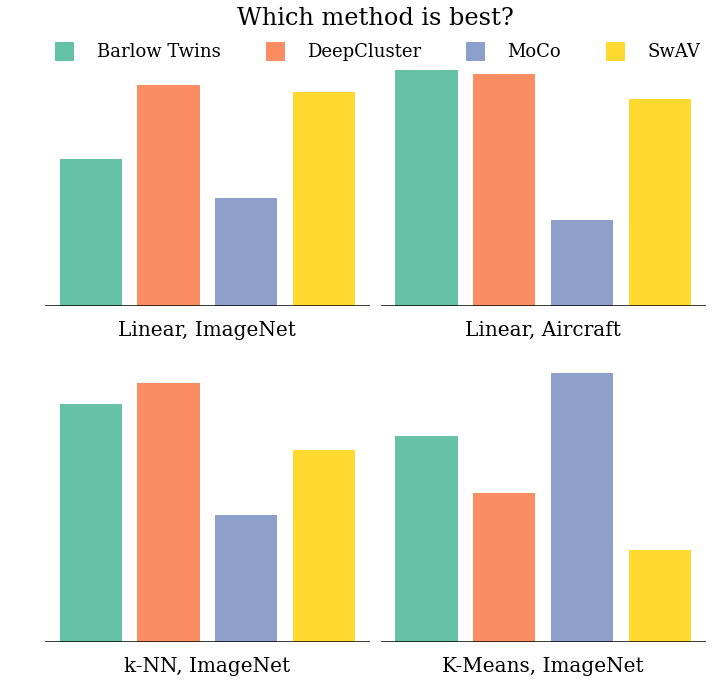

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
cmap = plt.get_cmap('Set2')
plt.rcParams["font.family"] = "serif"
plt.rcParams['axes.titlepad'] = 0  # pad is in points...
#plt.rcParams['axes.titlepad'] = -15  # pad is in points...
colormap = np.array(list(cmap.colors))


#### PREP RESULTS ####

linear_results = {
    'btwins': {
        'val': {
            'res5': {
                'mean': 71.78
            }
        }
    },
    'dc': {
        'val': {
            'res5': {
                'mean': 75.19
            }
        }
    },
    'moco': {
        'val': {
            'res5': {
                'mean': 69.95
            }
        }
    },
    'sclr': {
        'val': {
            'res5': {
                'mean': 68.95
            }
        }
    },
    'simsiam': {
        'val': {
            'res5': {
                'mean': 67.89
            }
        }
    },
    'sup': {
        'val': {
            'res5': {
                'mean': 76.04 
            }
        }
    },
    'swav': {
        'val': {
            'res5': {
                'mean': 74.87
            }
        }
    }
}

#teaser_method_names = ['btwins', 'dc', 'moco', 'sup']
#teaser_method_names = ['btwins', 'moco', 'swav', 'sup']
teaser_method_names = ['btwins', 'dc', 'moco', 'swav']

teaser_linear_results = {}
for method_name in teaser_method_names:
    teaser_linear_results[method_name] = linear_results[method_name]['val']['res5']['mean']
    
teaser_linear_results_fgvc = {}
for method_name in teaser_method_names:
    teaser_linear_results_fgvc[method_name] = linear_results_fgvc[method_name]['val']['res5']['mean']

teaser_method_names = ['btwins', 'dc', 'moco', 'swav']
#teaser_method_names = ['btwins', 'moco', 'swav', 'sup']
method_names = ['btwins_r50_1000', 'dcv2_r50_800', 'moco_r50_800', 'swav_r50_800']
#method_names = ['btwins_r50_1000', 'moco_r50_800', 'swav_r50_800', 'supervised_r50']

teaser_knn_results = {}
for i, method_name in enumerate(method_names):
    teaser_knn_results[teaser_method_names[i]] = knn_results[method_name]['top1_mean']

teaser_kmeans_results = {}
for i, method_name in enumerate(method_names):
    teaser_kmeans_results[teaser_method_names[i]] = kmeans_results[method_name] * 100
    
#print(teaser_linear_results)
#print(teaser_linear_results_fgvc)
#print(teaser_knn_results)
#print(teaser_kmeans_results)


#### MAKE FIGURE ####

#method_names_sup = ['btwins', 'moco', 'swav', 'sup']
#method_names_sim = ['btwins', 'moco', 'swav', 'sup']
method_names_sup = ['btwins', 'dc', 'moco', 'swav']
method_names_sim = ['btwins', 'dc', 'moco', 'swav']
method_ids_sup = [0, 1, 2, 5]
method_ids_sim = [0, 1, 2, 5]
method_ids = [0, 1, 2, 5]

fig, axs = plt.subplots(2, 2)

axs[0, 0].bar([1, 2, 3, 4], list(teaser_linear_results.values()), color=colormap[method_ids_sup])
axs[0, 0].set_ylim(min(list(teaser_linear_results.values())) - 5, max(list(teaser_linear_results.values())) + 3.5)
axs[0, 0].axhline(y=min(list(teaser_linear_results.values())) - 5, color='black', linestyle='-')

axs[0, 1].bar([1, 2, 3, 4], list(teaser_linear_results_fgvc.values()), color=colormap[method_ids_sup])
axs[0, 1].set_ylim(min(list(teaser_linear_results_fgvc.values())) - 5, max(list(teaser_linear_results_fgvc.values())) + 3.5)
axs[0, 1].axhline(y=min(list(teaser_linear_results_fgvc.values())) - 5, color='black', linestyle='-')

axs[1, 0].bar([1, 2, 3, 4], list(teaser_knn_results.values()), color=colormap[method_ids_sim])
axs[1, 0].set_ylim(min(list(teaser_knn_results.values())) - 5, max(list(teaser_knn_results.values())) + 1.5)
axs[1, 0].axhline(y=min(list(teaser_knn_results.values())) - 5, color='black', linestyle='-')

axs[1, 1].bar([1, 2, 3, 4], list(teaser_kmeans_results.values()), color=colormap[method_ids_sim])
axs[1, 1].set_ylim(min(list(teaser_kmeans_results.values())) - 5, max(list(teaser_kmeans_results.values())) + 1.5)
axs[1, 1].axhline(y=min(list(teaser_kmeans_results.values())) - 5, color='black', linestyle='-')

axs[0, 0].set_xticks([])
axs[0, 1].set_xticks([])
axs[1, 0].set_xticks([])
axs[1, 1].set_xticks([])

axs[0, 0].set_title('Linear, ImageNet', fontsize=20, y=-0.1)
axs[0, 1].set_title('Linear, Aircraft', fontsize=20, y=-0.1)
axs[1, 0].set_title('k-NN, ImageNet', fontsize=20, y=-0.1)
axs[1, 1].set_title('K-Means, ImageNet', fontsize=20, y=-0.1)

axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')

plt.rcParams['axes.titley'] = .975

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.title('Which method is best?', fontsize=24)
f = lambda m,c: plt.plot([],[],marker=m, markersize=18, color=c, ls="none")[0]
handles = [f("s", colormap[i]) for i in method_ids]
fig.legend(handles,
          ['Barlow Twins', 'DeepCluster', 'MoCo', 'SwAV'],
          ncol=4,
          fontsize=18,
          #loc=(0.055, 0.88), 
          loc=(0.055, 0.90), 
          frameon=False)  

fig.tight_layout()
fig.subplots_adjust(bottom=0.1) 
plt.savefig('teaser_square.pdf', bbox_inches = 'tight', pad_inches = 0.1)

In [35]:
import numpy as np

dataset = 'imagenet'

#### GET CKA RESULTS ####

results = {}
with open('/cfarhomes/mgwillia/unsupervised-analysis/outfiles/calc_cka_all.out.972111', 'r') as read_file:
    lines = read_file.readlines()
    for line in lines[1:]:
        line = line.strip()
        dataset = line.split(' ')[1][:-1]
        method_a = line.split(' ')[3][:-1]
        method_b = line.split(' ')[5][:-1]
        layer = line.split(' ')[7][:-1]
        cka = float(line.split(' ')[9])
        
        if dataset not in results:
            results[dataset] = {}
        if method_a not in results[dataset]:
            results[dataset][method_a] = {}
        if method_b not in results[dataset][method_a]:
            results[dataset][method_a][method_b] = {}
        
        results[dataset][method_a][method_b][layer] = cka
cka_results = results[dataset].copy()
method_names = [
    'supervised_r50',
    'btwins_r50_1000',
    'dcv2_r50_800',
    'moco_r50_800',
    'simclr_r50_800',
    'simsiam_r50_100',
    'swav_r50_800']
dataset = 'imagenet'
cka_matrix = np.zeros((len(cka_results), len(cka_results)))
for i, method_a in enumerate(method_names):
    for j, method_b in enumerate(method_names):
        cka_matrix[i][j] = cka_results[method_a][method_b]['res5']


#### GET NN OVERLAP RESULTS ####

root = '/vulcanscratch/mgwillia/unsupervised-classification/imagenet-'
btwins_neighbors = np.load(root + 'btwins/pretext/topk-val-neighbors.npy')[:,1:]
dc_neighbors = np.load(root + 'dc/pretext/topk-val-neighbors.npy')[:,1:]
moco_neighbors = np.load(root + 'moco/pretext/topk-val-neighbors.npy')[:,1:]
sclr_neighbors = np.load(root + 'sclr/pretext/topk-val-neighbors.npy')[:,1:]
simsiam_neighbors = np.load(root + 'simsiam/pretext/topk-val-neighbors.npy')[:,1:]
sup_neighbors = np.load(root + 'sup/pretext/topk-val-neighbors.npy')[:,1:]
swav_neighbors = np.load(root + 'swav/pretext/topk-val-neighbors.npy')[:,1:]

method_names = ['supervised', 'btwins', 'dc', 'moco', 'simclr', 'simsiam', 'swav']
neighbors = [sup_neighbors, btwins_neighbors, dc_neighbors, moco_neighbors, sclr_neighbors, simsiam_neighbors, swav_neighbors]

print('class-agonstic NN similarity, using 50 NNs:')
sim_map = {}
num_images_to_sample = btwins_neighbors.shape[0] #TODO: change to 100k, eventually do all of them!
for i in range(len(neighbors)):
    neighbors_a = neighbors[i]
    for j in range(i + 1, len(neighbors)):
        print(method_names[i], method_names[j])
        neighbors_b = neighbors[j]
        num_common_neighbors = 0
        #indices_to_sample = np.random.choice(range(neighbors_a.shape[0]), size=num_images_to_sample, replace=False).tolist()
        indices_to_sample = list(range(btwins_neighbors.shape[0]))
        for k in indices_to_sample:
            num_common_neighbors += np.intersect1d(neighbors_a[k], neighbors_b[k]).shape[0]
        sim = num_common_neighbors / (num_images_to_sample * neighbors_a.shape[1])
        #print(sim)
        if method_names[i] not in sim_map:
            sim_map[method_names[i]] = {}
        if method_names[j] not in sim_map:
            sim_map[method_names[j]] = {}
        sim_map[method_names[i]][method_names[j]] = sim
        sim_map[method_names[j]][method_names[i]] = sim
nn_overlap_matrix = np.zeros((len(method_names), len(method_names)))
for i, method_a in enumerate(method_names):
    for j, method_b in enumerate(method_names):
        if method_a == method_b:
            nn_overlap_matrix[i][j] = 1.0
        else:
            nn_overlap_matrix[i][j] = sim_map[method_a][method_b]


#### GET LIN OVERLAP RESULTS ####

method_names = ['supervised_r50', 'btwins_r50_1000', 'dcv2_r50_800', 'moco_r50_800', 'simclr_r50_800', 'simsiam_r50_100', 'swav_r50_800']
vissl_dir = '/vulcanscratch/mgwillia/vissl/predictions/'

#dataset = 'cub'
predictions = {}
for method_name in method_names:
    if method_name not in results:
        results[method_name.split('_')[0]] = {}

    val_predictions = torch.load(os.path.join(vissl_dir, '_'.join([method_name, dataset, 'predictions']) + '.pth.tar'))['val_predictions']
    val_targets = torch.load(os.path.join(vissl_dir, '_'.join([method_name, dataset, 'targets']) + '.pth.tar'))['val_targets'].numpy()

    predictions[method_name.split('_')[0]] = val_predictions['res5'].numpy()

overlap_map = {}
for i in range(len(method_names)):
    method_i = method_names[i].split('_')[0]
    for j in range(i + 1, len(method_names)):
        method_j = method_names[j].split('_')[0]
        if method_i not in overlap_map:
            overlap_map[method_i] = {}
        if method_j not in overlap_map:
            overlap_map[method_j] = {}
        overlap = np.where(predictions[method_i] == predictions[method_j], 1, 0).mean()
        overlap_map[method_i][method_j] = overlap
        overlap_map[method_j][method_i] = overlap
lin_overlap_matrix = np.zeros((len(method_names), len(method_names)))
for i, method_a in enumerate(method_names):
    for j, method_b in enumerate(method_names):
        if method_a == method_b:
            lin_overlap_matrix[i][j] = 1.0
        else:
            lin_overlap_matrix[i][j] = overlap_map[method_a.split('_')[0]][method_b.split('_')[0]]


class-agonstic NN similarity, using 50 NNs:
supervised btwins
supervised dc
supervised moco
supervised simclr
supervised simsiam
supervised swav
btwins dc
btwins moco
btwins simclr
btwins simsiam
btwins swav
dc moco
dc simclr
dc simsiam
dc swav
moco simclr
moco simsiam
moco swav
simclr simsiam
simclr swav
simsiam swav


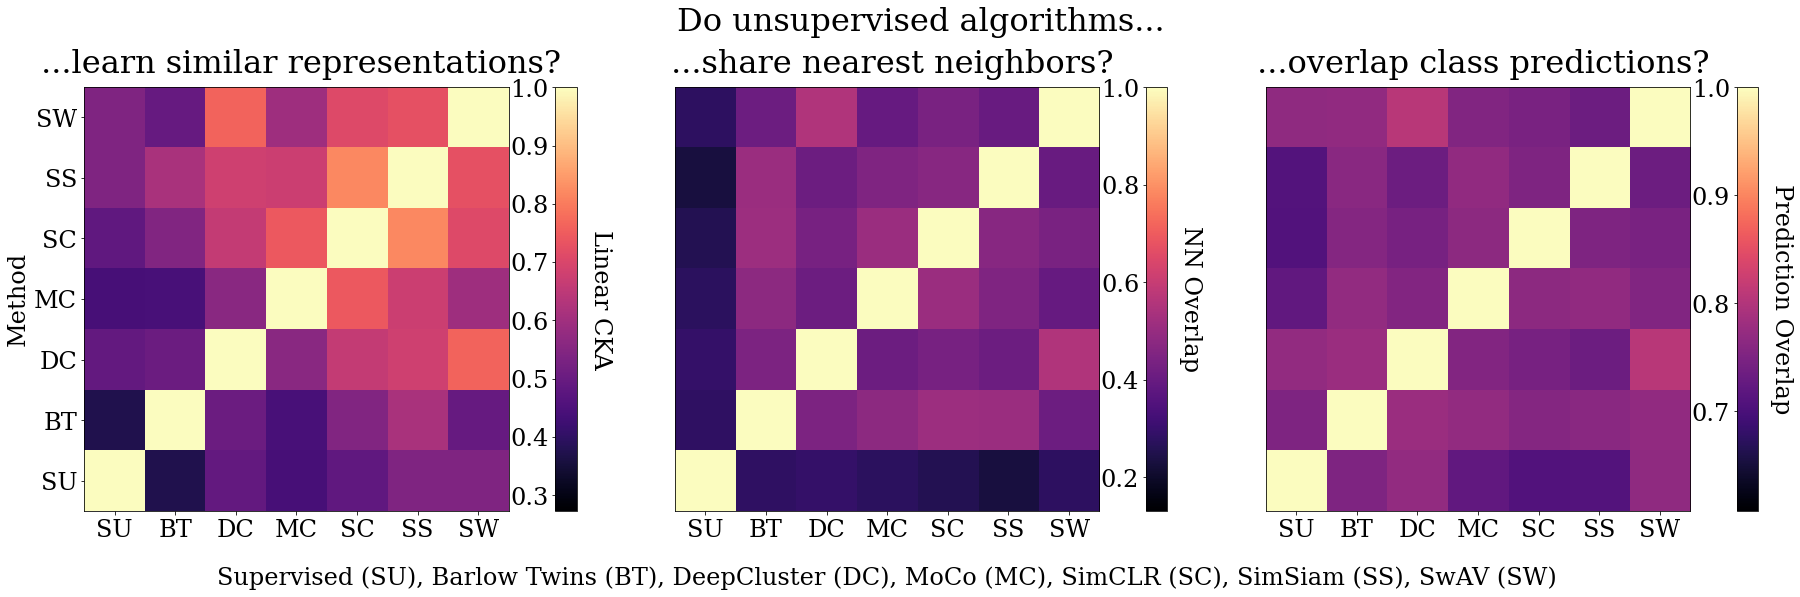

In [46]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (30,10)
plt.rcParams['axes.titlepad'] = 0  # pad is in points...
plt.rcParams["font.family"] = "serif"

#### MAKE FIGURE ####

tick_size = 24#32
label_size = 24#40
title_size = 32#48

fig, axs = plt.subplots(1, 3)
method_tick_labels = ['SU', 'BT', 'DC', 'MC', 'SC', 'SS', 'SW']

color_values_0 = axs[0].imshow(cka_matrix, origin='lower', vmin=cka_matrix.min() - 0.1, cmap=plt.get_cmap('magma'))
axs[0].set_xticks(list(range(0, len(method_tick_labels))))
axs[0].set_yticks(list(range(0, len(method_tick_labels))))
axs[0].set_xticklabels(method_tick_labels)
axs[0].set_yticklabels(method_tick_labels)
axs[0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[0].tick_params(axis='both', which='minor', labelsize=tick_size)
axs[0].set_title(' \n ...learn similar representations?', fontsize=title_size, pad=25)
axs[0].set_ylabel('Method', fontsize=label_size)

color_values_1 = axs[1].imshow(nn_overlap_matrix, origin='lower', vmin=nn_overlap_matrix.min() - 0.1, cmap=plt.get_cmap('magma'))
axs[1].set_xticks(list(range(0, len(method_tick_labels))))
axs[1].set_yticks([])
axs[1].set_xticklabels(method_tick_labels)
axs[1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1].tick_params(axis='both', which='minor', labelsize=tick_size)
axs[1].set_title(' \n ...share nearest neighbors?', fontsize=title_size, pad=25)
axs[1].set_xlabel('Supervised (SU), Barlow Twins (BT), DeepCluster (DC), MoCo (MC), SimCLR (SC), SimSiam (SS), SwAV (SW)', fontsize=label_size)
axs[1].xaxis.labelpad = 25

color_values_2 = axs[2].imshow(lin_overlap_matrix, origin='lower', vmin=lin_overlap_matrix.min() - 0.1, cmap=plt.get_cmap('magma'))
axs[2].set_xticks(list(range(0, len(method_tick_labels))))
axs[2].set_yticks([])
axs[2].set_xticklabels(method_tick_labels)
axs[2].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2].tick_params(axis='both', which='minor', labelsize=tick_size)
axs[2].set_title(' \n ...overlap class predictions?', fontsize=title_size, pad=25)

cbar_0 = fig.colorbar(color_values_0, ax=axs[0], pad=0.095, fraction=0.043) #0.046 is the magic value, but I want mine shorter
cbar_0.ax.tick_params(labelsize=tick_size) 
cbar_0.set_label('Linear CKA', rotation=270, fontsize=label_size, labelpad=35)
cbar_0.ax.yaxis.set_ticks_position('left')

cbar_1 = fig.colorbar(color_values_1, ax=axs[1], pad=0.095, fraction=0.043)
cbar_1.ax.tick_params(labelsize=tick_size) 
cbar_1.set_label('NN Overlap', rotation=270, fontsize=label_size, labelpad=35)
cbar_1.ax.yaxis.set_ticks_position('left')

cbar_2 = fig.colorbar(color_values_2, ax=axs[2], pad=0.095, fraction=0.043, ticks=[0.7, 0.8, 0.9, 1.0])
cbar_2.ax.tick_params(labelsize=tick_size) 
cbar_2.set_label('Prediction Overlap', rotation=270, fontsize=label_size, labelpad=35)
cbar_2.ax.yaxis.set_ticks_position('left')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.title('Do unsupervised algorithms...', fontsize=title_size, pad=10.0)
#plt.xlabel('Method', fontsize=32)

#fig.tight_layout()
#fig.subplots_adjust(bottom=0.1) 
plt.savefig('teaser_star.pdf', bbox_inches = 'tight', pad_inches = 0.05)